In [23]:
import os
from astropy.table import Table, vstack
import numpy as np
from collections import OrderedDict
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from astropy.table import Table, vstack, Column
from astropy.io import ascii
import scipy, pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits as pyfits

In [315]:
def starmask(ra, dec, mag):
    # Tycho-2 catlaog from Pickles & Depagne (2010) 
    tb = Table.read('tycho.fits')
    tb.rename_column('RAJ2000', 'ra')
    tb.rename_column('DEJ2000', 'dec')

    # mag cut
    mag = mag
    
    tb = tb[tb['Vfmag']<mag]

    # position cut
    pos_cut = (((tb['ra'] > 290) | (tb['ra'] < 80)) & (tb['dec'] > -21))
    pos_cut |= (((tb['ra'] < 260) & (tb['ra'] > 120)) & (tb['dec'] > -10))
    tb = tb[pos_cut]
    
    min_sep = 60 # arcsec

    cat_coord = SkyCoord(ra, dec, unit='deg')
    tycho_coord = SkyCoord(tb['ra'], tb['dec'], unit='deg')
    idx, sepz, _ = cat_coord.match_to_catalog_sky(tycho_coord)
    #print((sepz.arcsec > min_sep).sum(), 'candidates near bright stars')

    cut = sepz.arcsec > min_sep    # get all objects that are above this minimum separation from bright stars
    
    return cut

In [661]:
t8 = Table.read('/u/tmakinen/repositories/tractor-scratch/159.fits')

In [663]:
idarr = []
for i in range(len(t8['brickid'])):
    idarr.append('brick' + str(t8['brickid'][i]) + '_id' + str(t8['objid'][i]))
t8['id'] = idarr

In [664]:
t8

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18
159.088896198,-3.28960310254,EXP,312285,2196,59.5177,38.0004,71.3137,5.338,0.999098 .. 46.7575,0.515107 .. 34.3634,1.1085 .. 60.6989,-0.238071,-0.070132,1.08651,23.1518,brick312285_id2196
159.067602956,-3.27281130294,REX,312285,2601,9.87441,4.28397,21.852,12.4114,0.692637 .. 117.91,0.365988 .. 76.8179,0.87095 .. 162.089,0.0,0.0,1.08679,23.3085,brick312285_id2601
159.198897221,-3.45026646439,EXP,310847,4427,2.62086,2.23332,1.23637,6.04653,0.107705 .. 23.0822,0.00553684 .. 15.6564,0.124356 .. 32.1278,-0.544735,0.475377,1.05284,25.0042,brick310847_id4427
158.992855735,-4.68531034035,EXP,303660,3245,39.5425,22.666,55.7086,5.19938,1.00867 .. 33.9689,0.46969 .. 22.8163,1.36468 .. 48.3144,-0.27098,0.0816496,1.04212,23.4444,brick303660_id3245
159.077477502,-4.9974695482,REX,302224,1146,247.974,127.752,518.146,50.1091,0.0548604 .. 105.74,0.0229723 .. 148.01,0.13042 .. 175.258,0.0,0.0,1.01749,25.1884,brick302224_id1146
158.913291892,-5.37529158392,EXP,299353,4897,4.20115,3.47912,3.29694,8.35351,0.211592 .. 61.1595,0.0964366 .. 33.8793,0.278814 .. 97.0212,0.324556,0.565452,1.30948,24.2864,brick299353_id4897
159.024767485,-5.69640560639,EXP,297919,4248,9.73504,5.40029,16.2544,5.26283,0.494097 .. 11.2872,0.30589 .. 6.25816,0.60494 .. 15.8098,-0.804063,0.163315,1.19721,24.1185,brick297919_id4248
159.053522112,-6.02029673724,EXP,296485,2920,8.77353,7.09162,5.74538,5.29314,0.313833 .. 43.2723,0.227313 .. 31.3018,0.3344 .. 55.3403,-0.433818,-0.452343,1.29054,23.9295,brick296485_id2920


In [666]:
comp1 = Table.read('comparison/159test-objects.csv')
idarr = []
for i in range(len(t8['brickid'])):
    idarr.append('brick' + str(t8['brickid'][i]) + '_id' + str(t8['objid'][i]))
t8['id'] = idarr

In [667]:
type_arr = [''] * len(t8['id'])
for i in range(len(t8['id'])):
    for j in range(len(comp1['id'])):
        if t8['id'][i] == comp1['id'][j]:
            type_arr[i] = comp1['actual_type'][j]
            
t8['tag'] = type_arr;

In [668]:
t8['tag'] = type_arr;

In [669]:
e1 = t8['shapeexp_e1']
e2 = t8['shapeexp_e2']

abse = np.sqrt(e1**2 + e2**2)
ratio = (1 - abse)/(1+abse)

t8['ratio'] = ratio

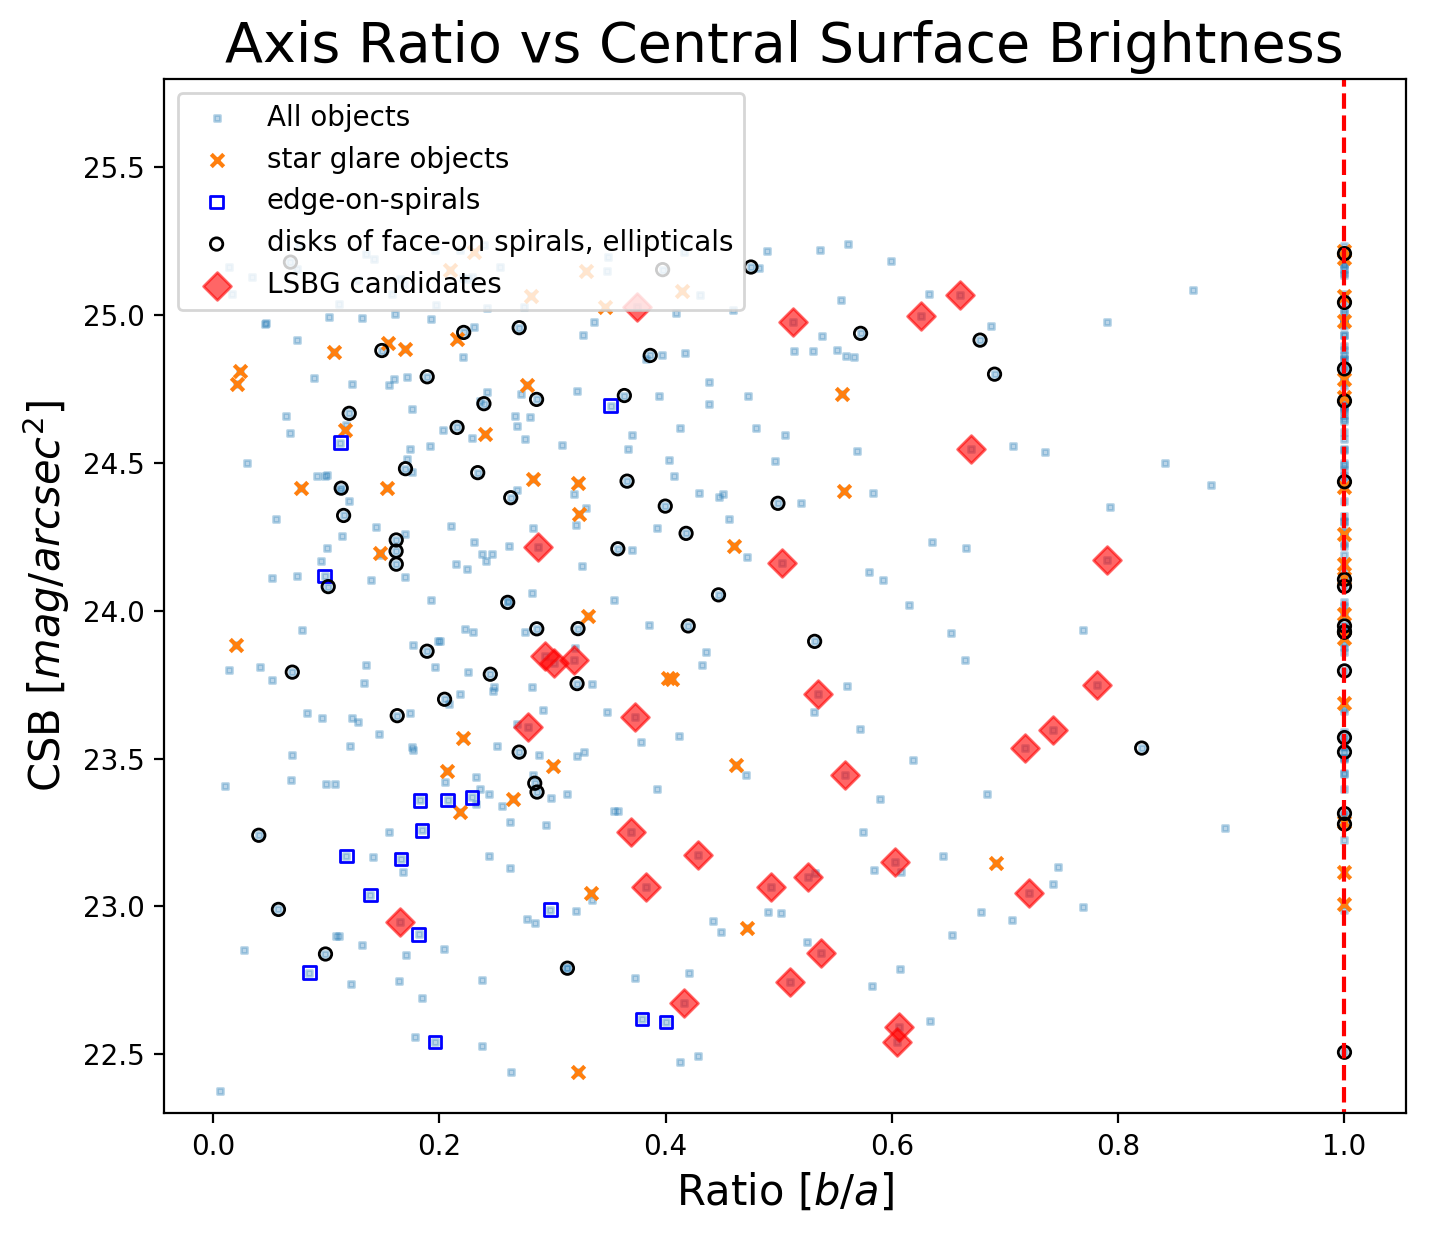

In [885]:
#------plot ----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# object types

star = t8['tag'] == 's'
spiral = t8['tag'] == 'sp'
misc = t8['tag'] == 'c'
disk = t8['tag'] == 'd'
lsbg = t8['tag'] == 'l'
best = t8['tag'] == 'lg'
best &= t8['ratio'] < 1

ratio = t8['ratio']
csb = t8['csb_g']


x = np.full((560), 1 )
y = np.linspace(20, 28, 560)
ax1.plot(x,y, c = 'r', linestyle='--')

# make scatterplots 
background = ax1.scatter(ratio, csb, s=4, marker = "s", alpha=0.3, label = 'All objects')
stars = ax1.scatter(ratio[star], csb[star], s=20, marker='x', alpha=1, edgecolors='g', label='star glare objects')
spirals = ax1.scatter(ratio[spiral], csb[spiral], s=20, marker='s', facecolors='none', alpha=1, edgecolors='b', label='edge-on-spirals')
disks = ax1.scatter(ratio[disk], csb[disk], s=20, marker='o', facecolors='none', alpha=1, edgecolors='k', label='disks of face-on spirals, ellipticals')
#lsbg = ax1.scatter(ratio[lsbg], csb[lsbg], s=20, marker='D', facecolors='none', alpha=0.6, edgecolors='r', label='potential LSBGs')
best_lsbg = ax1.scatter(ratio[best | lsbg], csb[best | lsbg], s=50, marker='D', facecolors='r', alpha=0.6, edgecolors='r', label='LSBG candidates')


#cbar = plt.colorbar(sctrac)
#cbar.set_label('Central Surface Brightness',labelpad=10)


# add johnny's function
#fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
#age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
#ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")

#plt.xlim((, 2))
plt.ylim((22.3, 25.8))
plt.title('Axis Ratio vs Central Surface Brightness', fontsize=20)
plt.xlabel('Ratio [$b/a$]', fontsize=15)
plt.ylabel('CSB [$mag/arcsec^2$]', fontsize=15)

plt.legend(loc='upper left')
plt.tight_layout()


plt.savefig("/u/tmakinen/Documents/JP-1/pics/failurestate-ratio.png", dpi='figure', bbox_inches='tight', overwrite=True)

plt.show()


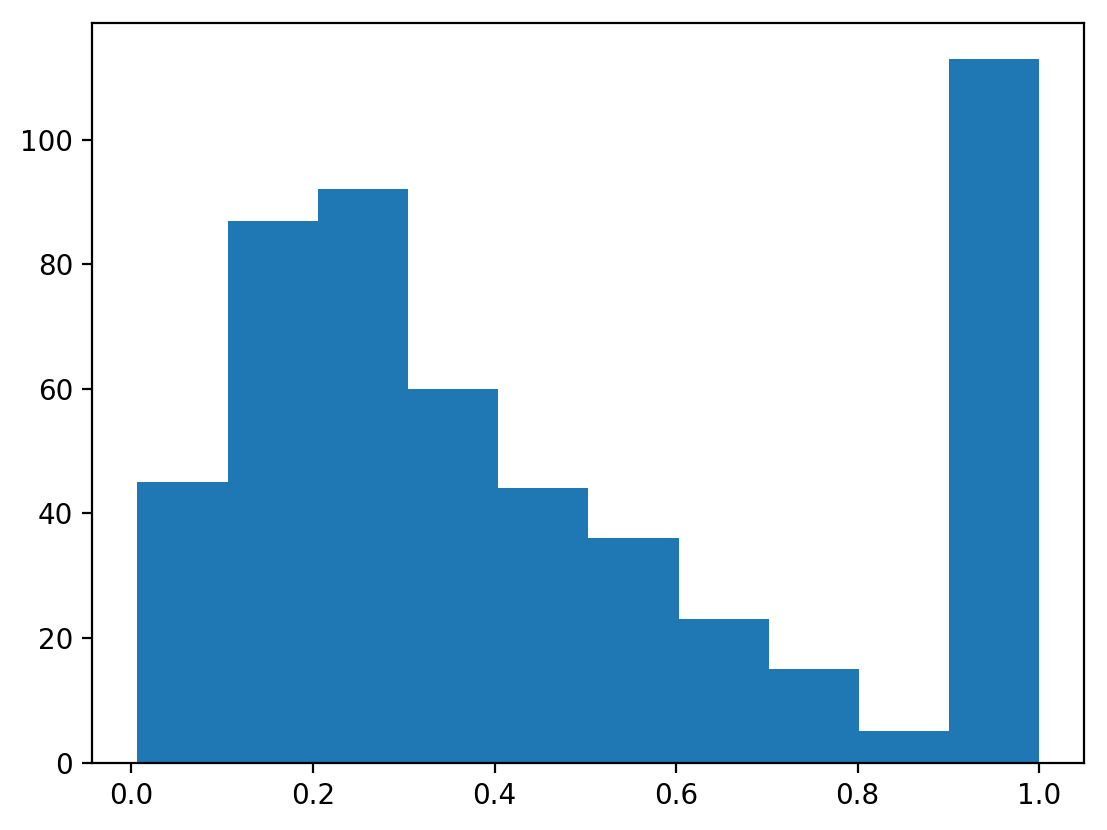

In [672]:
plt.hist(test['eccen']);

In [305]:
mask = (t['eccen'] > 0.3) & (t['eccen'] < 0.85)

In [306]:
t4 = t[mask]

print(len(t4))

182


In [195]:
for i in range(len(t4['eccen'])):
    if t4['type'][i] == 'COMP':
        #print(t4['eccen'][i]);

SyntaxError: unexpected EOF while parsing (<ipython-input-195-a88810be82bf>, line 3)

In [118]:
output = test[0::3].copy()
idarr = []

for i in range(len(output['brickid'])):
    idarr.append('brick' + str(output['brickid'][i]) + '_id' + str(output['objid'][i]))
output['id'] = idarr
#output.rename_column('objid', 'id')
output.rename_column('csb_g', 'csb')
output['id', 'ra', 'dec', 'type', 'shapeexp_r', 'csb', 'eccen' ].write('test159.fits', overwrite=True)

In [119]:
output;

In [382]:
t251 = Table.read('/u/tmakinen/repositories/tractor-scratch/251.fits')

In [383]:
e1 = t251['shapeexp_e1']
e2 = t251['shapeexp_e2']

abse = np.sqrt(e1**2 + e2**2)
ratio = (1 - abse)/(1+abse)

t251['eccen'] = ratio

In [385]:
mask = (t251['eccen'] > 0.3) & (t251['eccen'] < 0.85)
t5 = t251[mask]
t5

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,eccen
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
250.995762339,4.40209432296,EXP,357279,704,47.1081,30.4396,66.4816,6.80268,0.569178 .. 33.2975,0.32425 .. 21.3976,0.871075 .. 45.0039,0.112044,0.338661,1.3243,23.6618,0.474149
250.997896463,4.42095398434,EXP,357279,1236,24.309,17.106,29.8708,10.0391,0.249688 .. 15.5082,0.17619 .. 11.1741,0.222425 .. 19.7048,-0.438854,0.151918,1.32441,24.2562,0.365743
251.096469408,5.20788569084,EXP,361587,2098,8.20448,3.64405,12.8999,11.57,0.233749 .. 15.0962,0.101916 .. 6.68814,0.322229 .. 27.8717,0.0537181,0.143871,1.55942,24.3293,0.733745
251.011910327,16.0595220119,EXP,422412,3670,20.6685,9.11204,36.3525,11.9827,0.181839 .. 91.5721,0.101827 .. 33.1192,0.663243 .. 201.653,0.289284,0.375498,1.52875,24.5856,0.356844
251.07408616,17.4459364871,EXP,430693,1382,42.0949,13.7811,84.873,28.9329,0.160675 .. 49.7058,0.0845107 .. 17.9132,0.272621 .. 105.65,0.35663,-0.325088,1.40262,25.1765,0.349015
251.021673648,20.5110955198,EXP,447055,2230,7.40282,2.27257,21.8903,8.99193,0.320891 .. 36.7487,0.0966464 .. 18.4895,1.06082 .. 115.961,0.21632,-0.0706382,1.7627,25.0298,0.629247
251.091200657,24.6578955917,EXP,469673,490,52.121,34.0706,73.343,6.80224,0.911576 .. 54.7387,0.53197 .. 33.1032,1.70267 .. 62.5081,0.171318,-0.199649,1.8651,23.205,0.583434
251.005088031,31.3660771412,EXP,502758,2946,18.7757,19.5401,75.551,45.3286,0.207416 .. 825.143,0.0475003 .. 397.708,0.791911 .. 585.79,0.161142,0.427702,1.98999,24.5285,0.372636


In [386]:
output = t5.copy()
idarr = []

for i in range(len(output['brickid'])):
    idarr.append('brick' + str(output['brickid'][i]) + '_id' + str(output['objid'][i]))
output['id'] = idarr
#output.rename_column('objid', 'id')
output.rename_column('csb_g', 'csb')
output['id', 'ra', 'dec', 'type', 'shapeexp_r', 'csb', 'eccen' ].write('test251.fits', overwrite=True)

In [387]:
comp = Table.read('comparison/251test-objects.csv')

In [388]:
idarr = []

for i in range(len(t5['brickid'])):
    idarr.append('brick' + str(t5['brickid'][i]) + '_id' + str(t5['objid'][i]))
t5['id'] = idarr

In [389]:
type_arr = [''] * len(t5['id'])
for i in range(len(t5['id'])):
    for j in range(len(comp['id'])):
        if t5['id'][i] == comp['id'][j]:
            type_arr[i] = comp['actual_type'][j]
            
t5['tag'] = type_arr;

In [479]:
#------plot ratio vs csb----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# object types

star = t5['tag'] == 's'
spiral = t5['tag'] == 'sp'
misc = t5['tag'] == 'c'
disk = t5['tag'] == 'd'
lsbg = t5['tag'] == 'l'
best = t5['tag'] == 'lg'

ratio = t5['ratio']
csb = t5['csb_g']


# make scatterplots 
background = ax1.scatter(eccen, csb, s=4, marker = "s", alpha=0.3, label = 'All objects')
stars = ax1.scatter(eccen[star], csb[star], s=20, marker='X', alpha=1, edgecolors='g', label='star glare objects')
spirals = ax1.scatter(eccen[spiral], csb[spiral], s=20, marker='s', facecolors='none', alpha=1, edgecolors='b', label='edge-on-spirals')
disks = ax1.scatter(eccen[disk], csb[disk], s=20, marker='o', facecolors='none', alpha=1, edgecolors='k', label='disks of face-on spirals, ellipticals')
comp = ax1.scatter(eccen[disk], csb[disk], s=20, marker='x', facecolors='none', alpha=1, edgecolors='k', label='composition of small sources')
lsbg = ax1.scatter(eccen[lsbg], csb[lsbg], s=20, marker='D', facecolors='none', alpha=0.6, edgecolors='r', label='potential LSBGs')
best_lsbg = ax1.scatter(eccen[best], csb[best], s=30, marker='D', facecolors='r', alpha=1, edgecolors='r', label='best LSBG candidates')

#cbar = plt.colorbar(sctrac)
#cbar.set_label('Central Surface Brightness',labelpad=10)


# add johnny's function
#fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
#age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
#ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")

#plt.xlim((-2, 2))
#plt.ylim((-2, 2))
plt.title('ratio b vs central surface brightness')
plt.xlabel('ratio b/a')
plt.ylabel('central surface brightness (magnitude)')

plt.legend(loc='best')
plt.tight_layout()


#plt.savefig("color-color-model-good.png", dpi='figure', bbox_inches='tight')

plt.show()


IndentationError: expected an indented block (<ipython-input-479-b4aa1805a920>, line 3)

In [391]:
keep = (t5['tag'] == 'lg') | (t5['tag'] == 'l')

In [392]:
print(len(t5[keep]) / len(t5))

0.1937984496124031


In [400]:
def get_ratio(t):   # want ratio of major and minor axes b/a
    e1 = t['shapeexp_e1']
    e2 = t['shapeexp_e2']

    abse = np.sqrt(e1**2 + e2**2)
    ratio = (1 - abse)/(1+abse)

    t['ratio'] = ratio
    return t

In [401]:
def make_id(t):
    idarr = []

    for i in range(len(t['brickid'])):
        idarr.append('brick' + str(t['brickid'][i]) + '_id' + str(t['objid'][i]))
    t['id'] = idarr 
    return t

In [402]:
def get_tags(t, tag_t): # takes a table and a list of string tags
    type_arr = [''] * len(t['id'])
    for i in range(len(t['id'])):
        for j in range(len(tag_t['id'])):
            if t['id'][i] == tag_t['id'][j]:
                type_arr[i] = tag_t['actual_type'][j]

    t['tag'] = type_arr;
    return t

In [807]:
t1 = Table.read('twotractors.fits')

In [846]:
t1;

In [809]:
print(max(t1['ratio']))

0.960462


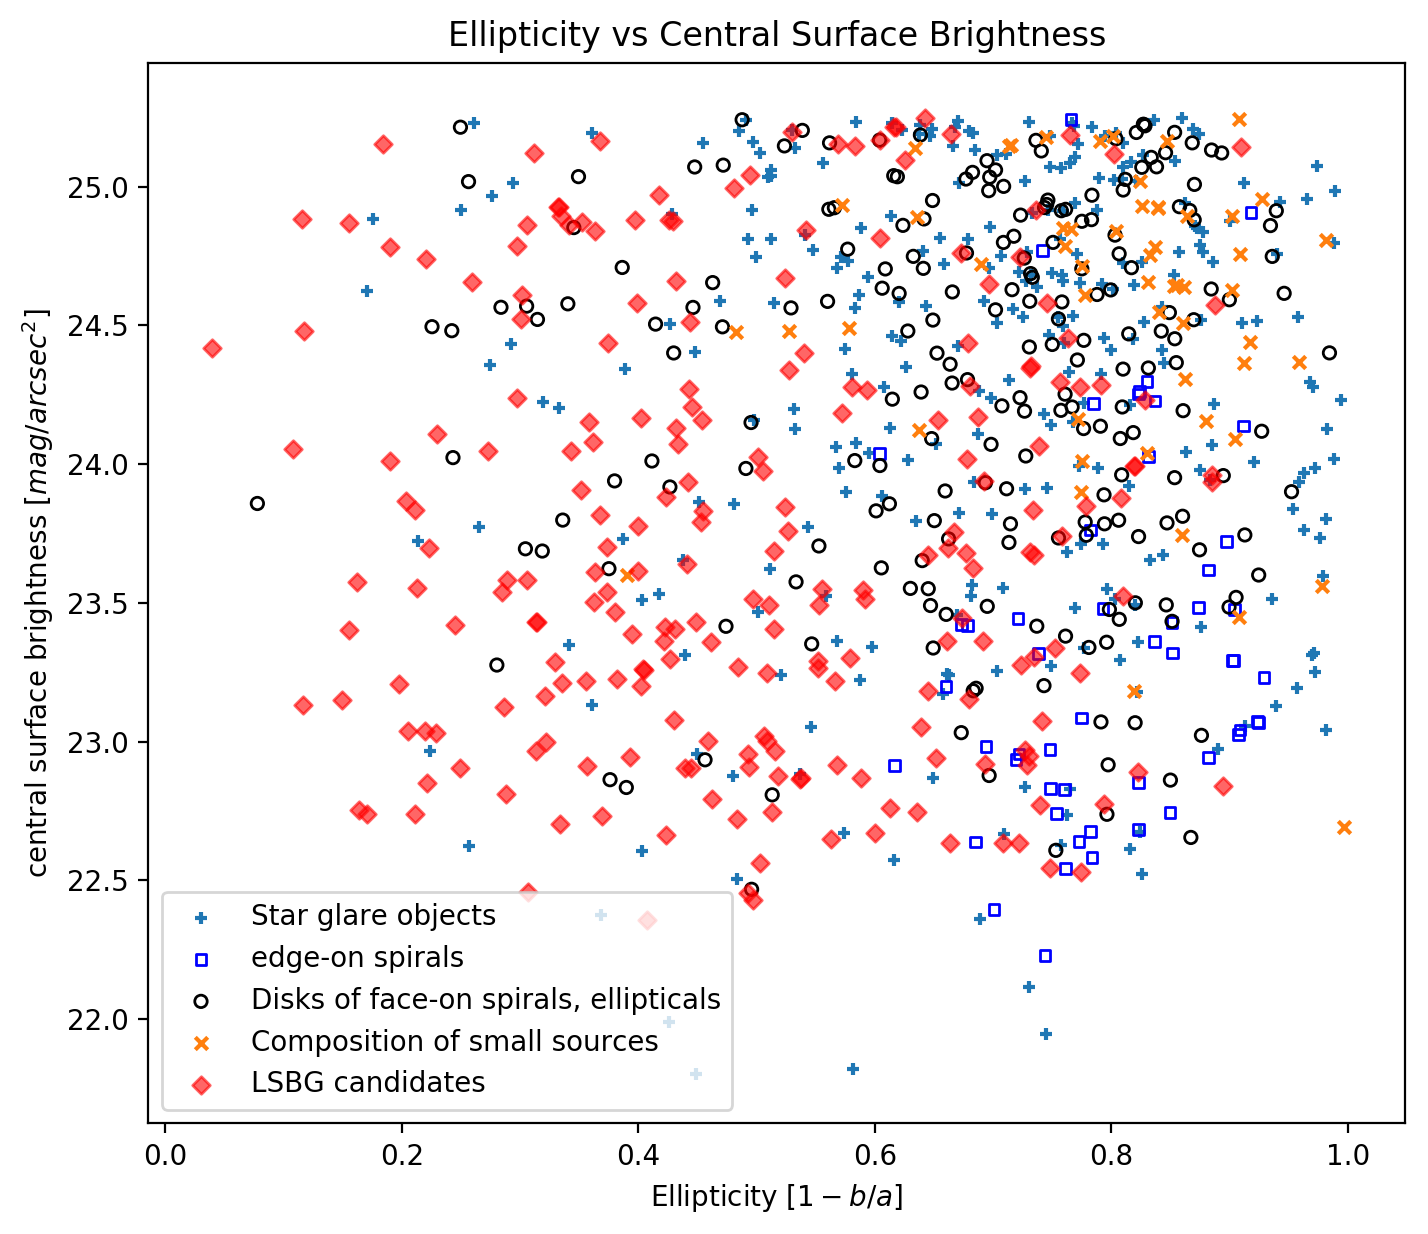

In [848]:
#------plot ratio vs csb----#
t5 = t1
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# object types

star = t5['tag'] == 's'
spiral = t5['tag'] == 'sp'
misc = t5['tag'] == 'c'
disk = t5['tag'] == 'd'
lsbg = t5['tag'] == 'l'
best = t5['tag'] == 'lg'

ellip = 1 - t5['ratio']
csb = t5['csb_g']


# make scatterplots 
#background = ax1.scatter(ratio, csb, s=4, marker = "s", alpha=0.3, label = 'All objects')
stars = ax1.scatter(ellip[star], csb[star], s=20, marker='+', alpha=1, edgecolors='g', label='Star glare objects')
spirals = ax1.scatter(ellip[spiral], csb[spiral], s=15, marker='s', facecolors='none', alpha=1, edgecolors='b', label='edge-on spirals')
disks = ax1.scatter(ellip[disk], csb[disk], s=20, marker='o', facecolors='none', alpha=1, edgecolors='k', label='Disks of face-on spirals, ellipticals')
comp = ax1.scatter(ellip[misc], csb[misc], s=20, marker='x', alpha=1, edgecolors='k', label='Composition of small sources')
lsbg = ax1.scatter(ellip[lsbg|best], csb[lsbg|best], s=20, marker='D', facecolors='r', alpha=0.6, edgecolors='r', label='LSBG candidates')
#best_lsbg = ax1.scatter(ellip[best], csb[best], s=30, marker='D', facecolors='r', alpha=1, edgecolors='r', label='best LSBG candidates')

#cbar = plt.colorbar(sctrac)
#cbar.set_label('Central Surface Brightness',labelpad=10)


# add johnny's function
#fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
#age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
#ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")

#plt.xlim((-2, 2))
#plt.ylim((-2, 2))
plt.title('Ellipticity vs Central Surface Brightness')
plt.xlabel('Ellipticity $[1 -b/a$]')
plt.ylabel('central surface brightness [$mag / arcsec^2$]')

plt.legend(loc='best')
plt.tight_layout()


#plt.savefig("color-color-model-good.png", dpi='figure', bbox_inches='tight')

plt.show()


In [887]:
hsc = Table.read('hsc_lsbgs.fits')

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


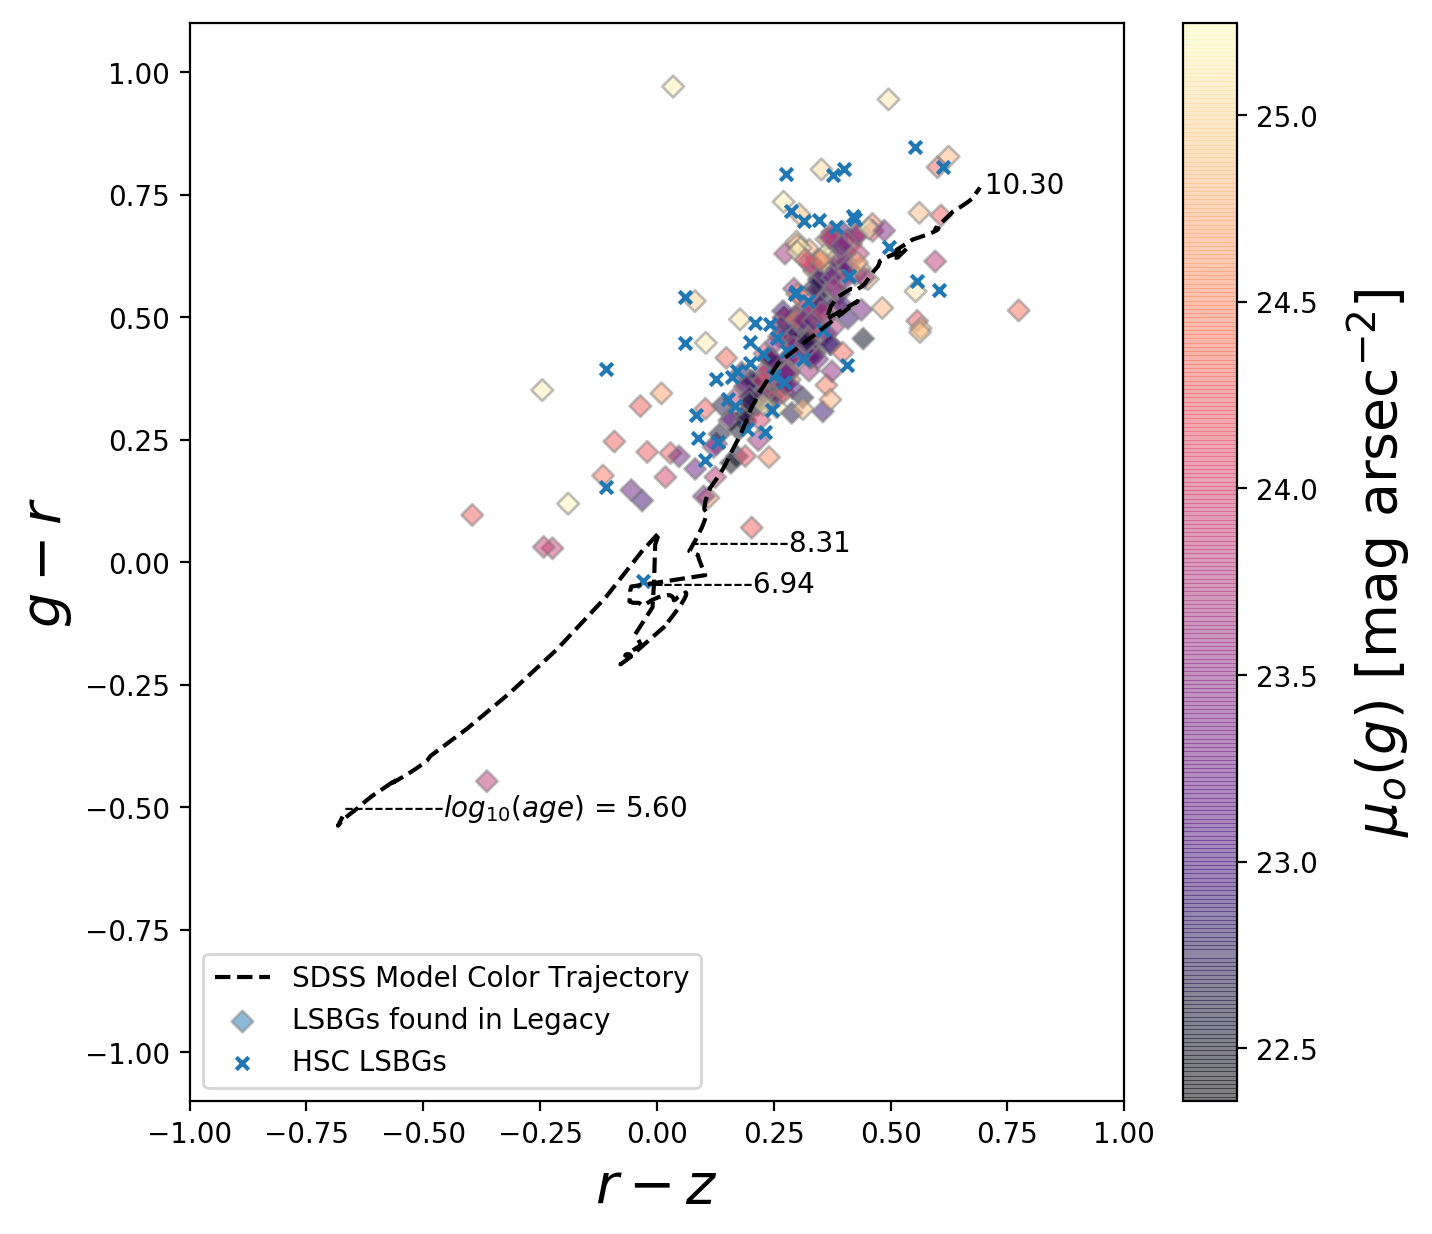

In [998]:
#------make the color-color (g-r), (r-z) band plot for the model fluxes----#
good = t1['tag'] == 'l'
best = t1['tag'] == 'lg'
lsbgs = t1[good | best]
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# convert out of nanomaggies for lsbg table (lol) #
#lsbg_mag_r = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
#lsbg_mag_g = 22.5 - 2.5*np.log10(lsbg_tab['flux_g'])
#lsbg_mag_z = 22.5 - 2.5*np.log10(lsbg_tab['flux_z'])

# for tractor file
mag_r = 22.5 - 2.5*np.log10(lsbgs['flux_r'])
mag_g = 22.5 - 2.5*np.log10(lsbgs['flux_g'])
mag_z = 22.5 - 2.5*np.log10(lsbgs['flux_z'])


hsc_r = 22.5 - 2.5*np.log10(hsc['flux_r'])
hsc_g = 22.5 - 2.5*np.log10(hsc['flux_g'])
hsc_z = 22.5 - 2.5*np.log10(hsc['flux_z'])
# Do the subtraction for ratio of logs

#lsgb_gr = lsbg_mag_g - lsbg_mag_r
#lsgb_rz = lsbg_mag_r - lsbg_mag_z

hsc_gr = hsc_g - hsc_r
hsc_rz = hsc_r - hsc_z

mag_gr = mag_g - mag_r
mag_rz = mag_r - mag_z

# for central surface brightness colorbar
#aperture = 2.0  # central aperture
#csb_r = ap_r[mask]/(np.pi*((aperture**2)))           # central surface brightness of aperture in r band


# make scatterplots 
sctrac = ax1.scatter(mag_rz, mag_gr, s=30, marker = "D", edgecolors='gray', c=lsbgs['csb_g'], cmap='magma', alpha=0.5, label = 'LSBGs found in Legacy')
#sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', facecolors='none', alpha=1, edgecolors='r', label='HSC LSBG objects')

hscplot = ax1.scatter(hsc_rz, hsc_gr, s=20, marker = "x", edgecolors='b', label = 'HSC LSBGs')

cbar = plt.colorbar(sctrac)
cbar.set_label('$\mu_o(g)$ [mag arsec$^{-2}$]',labelpad=10, fontsize=20)


# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
ax1.plot(r-z, g-r, color='k', linestyle="--", label="SDSS Model Color Trajectory")

plt.xlim((-1.0, 1.0))
plt.ylim((-1.1, 1.1))
#plt.title(' Legacy LSBGs Model Flux Color-Color diagram', fontsize=20)
plt.xlabel('$r-z$', fontsize=20)
plt.ylabel('$g-r$', fontsize=20)


plt.text((r-z)[10], (g-r)[10], '----------$log_{10}(age)$ = '+str("%.2f"%age[10]), horizontalalignment='left')

for i in range(len(age)):
    for j in age[65:160:55]:
        if age[i] == j:
            #plt.text((r-z)[i] + 0.1, (g-r)[i], str("%.2f"%(np.power(age[i], 10)/1E9)) + "Gyr")
            plt.text((r-z)[i] + 0.0, (g-r)[i], '----------'+str("%.2f"%age[i]), horizontalalignment='left')
            
plt.text((r-z)[200], (g-r)[200], ' ' + str("%.2f"%age[i]), horizontalalignment='left')


plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/u/tmakinen/Documents/JP-1/plots/Legacy-LSBGs-colorcolor.png", dpi='figure', bbox_inches='tight', overwrite=True)

plt.show()

In [958]:
len(age)

220

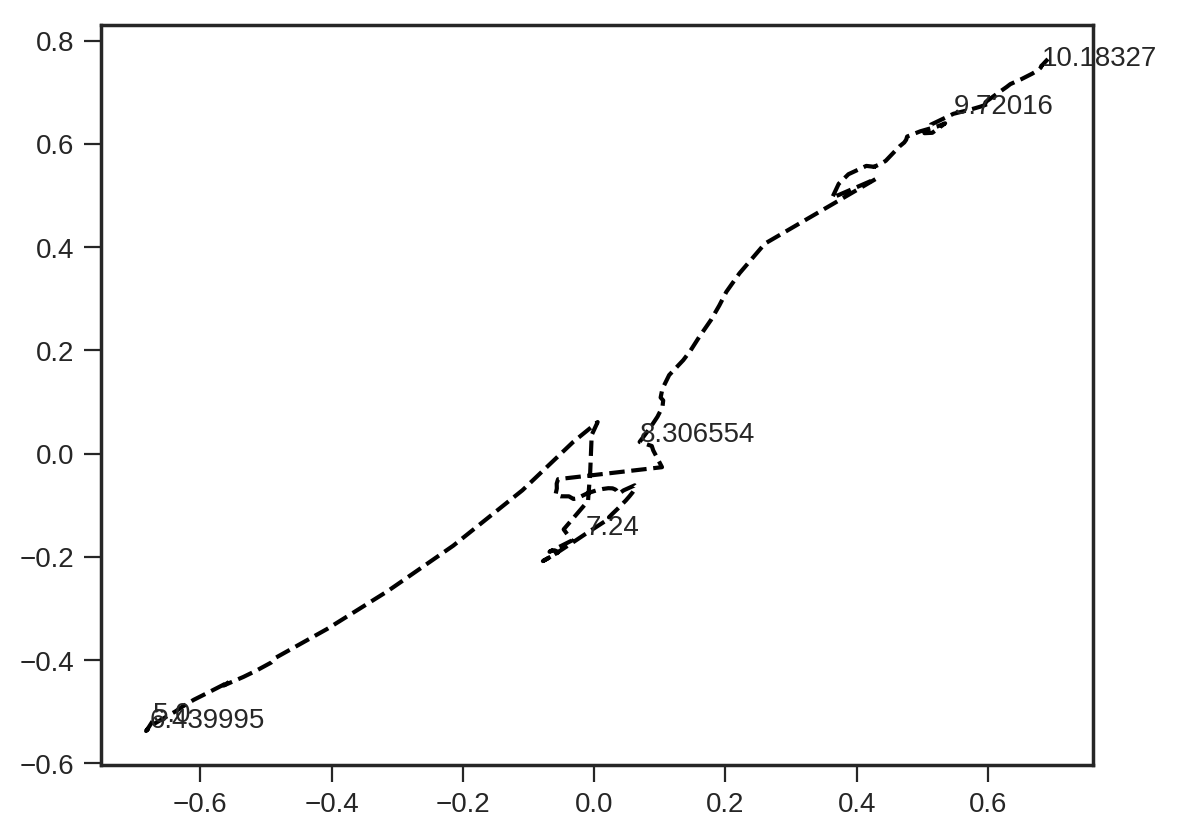

In [933]:
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
plt.plot(r-z, g-r, color='k', linestyle="--", label="SDSS Model Color Trajectory")



In [806]:
output = t1.copy()

output.write('twotractors.fits', overwrite=True)


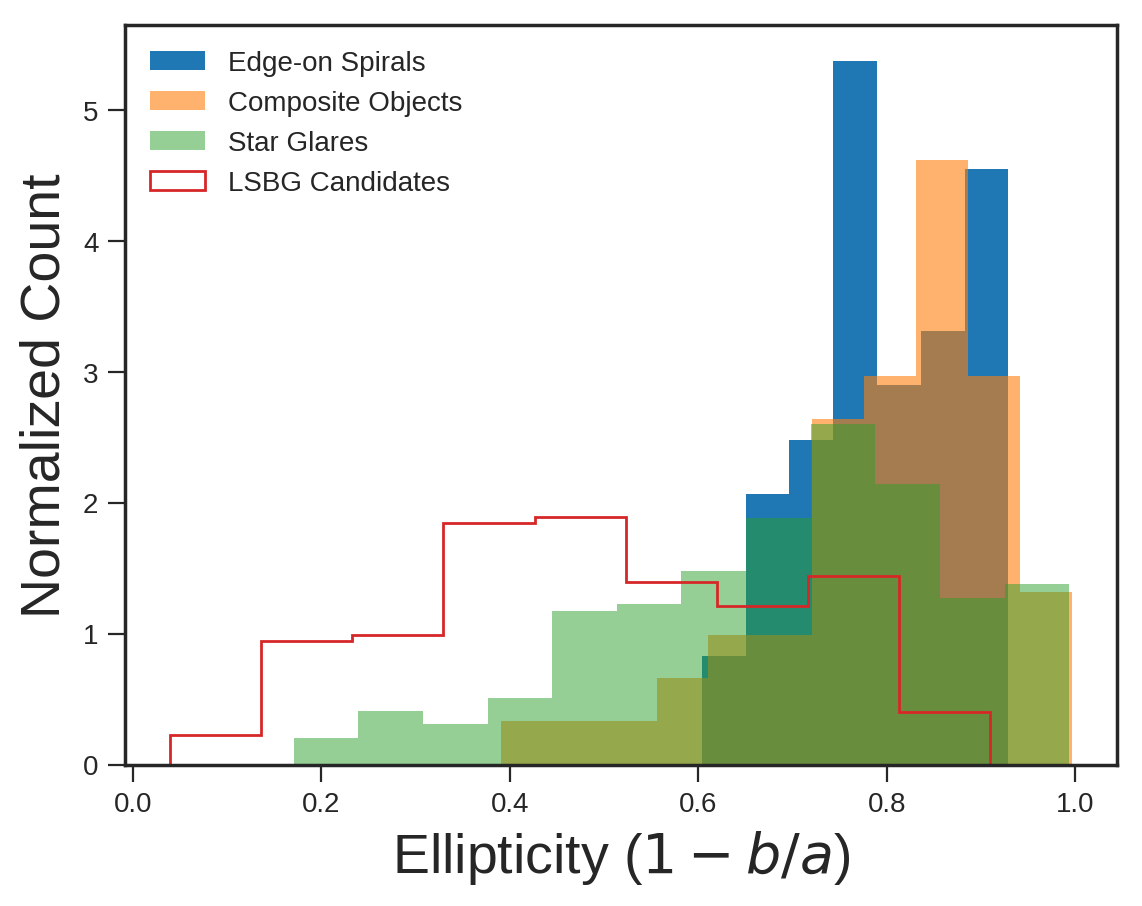

In [903]:
# object types
tf = t1
star = tf['tag'] == 's'
spiral = tf['tag'] == 'sp'
misc = tf['tag'] == 'c'
disk = tf['tag'] == 'd'
lsbg = tf['tag'] == 'l'
best = tf['tag'] == 'lg'

ellip = 1- tf['ratio']

x_arr = [ellip[disk], ellip[star], ellip[spiral], ellip[best | lsbg], ellip[best]]
label = ['disks', 'star glare', 'edge-on spirals', 'lsbg candidates', 'best lsbgs']
alpha = [1, 0.8, 0.6, 0.4, 1]
f = [True, True, True, False]
#edgecolors = 
#ax = plt.subplot(111)


plt.style.use('seaborn-ticks')


plt.hist(ellip[spiral], label = 'Edge-on Spirals', bins='auto', normed=True)
plt.hist(ellip[misc], label = 'Composite Objects', bins = 'auto', alpha=0.6, normed=True)
plt.hist(ellip[star], label='Star Glares', bins='auto', alpha=0.5, normed=True)
plt.hist(ellip[best | lsbg], label = 'LSBG Candidates', bins='auto',histtype='step', normed=True)
#plt.hist(ellip[best], label = 'Best LSBG Candidates', bins='auto',histtype='step', alpha=0.6, normed=True)

#plt.hist(ellip[best], label = 'best candidates', bins='auto', alpha=0.8)
plt.xlabel('Ellipticity ($1-b/a$)', fontsize=20)
plt.ylabel('Normalized Count', fontsize=20)
plt.legend()

plt.savefig("/u/tmakinen/Documents/JP-1/plots/ellipticity-his.png", 
                                    dpi='figure', bbox_inches='tight', overwrite=True)




In [909]:
print(len(ellip[misc]))

55


In [902]:
tf

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id,ratio,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,float32,str2
191.028373832,9.4905116223,EXP,385642,2050,75.5703,51.8018,97.138,5.78767,1.24013 .. 59.8921,0.759799 .. 41.9833,1.68281 .. 74.9112,0.299948,0.210714,1.45601,22.8665,brick385642_id2050,0.463525,l
190.951726889,9.62620858228,EXP,387063,7,4.33397,4.37913,18.805,23.7612,0.175933 .. 321.262,0.189064 .. 368.918,0.457112 .. 498.534,0.177217,-0.663925,1.41464,23.9199,brick387063_id7,0.185418,s
191.055452483,9.72328725791,EXP,387063,1560,290.051,165.943,400.595,17.3323,0.393809 .. 55.1326,0.195064 .. 32.5134,0.499615 .. 75.9131,-0.139655,-0.0733444,1.40064,24.0483,brick387063_id1560,0.727499,lg
191.110298532,9.85795382269,EXP,387063,3839,6.21865,3.00732,12.1122,9.00383,0.305057 .. 106.605,0.112822 .. 35.257,0.641561 .. 210.249,0.387841,0.574083,1.22929,24.4501,brick387063_id3839,0.181464,s
190.981726694,10.6117563685,EXP,391320,4513,49.1212,28.269,69.4795,7.8387,0.547143 .. 28.9159,0.312871 .. 16.7299,0.68774 .. 40.5038,-0.2108,0.0557095,1.4442,24.1519,brick391320_id4513,0.641986,lg
190.963159797,11.0462319905,EXP,394153,3289,20.9413,18.5698,29.623,5.2931,0.511645 .. 164.295,0.262914 .. 110.378,1.14023 .. 244.934,-0.097715,-0.279017,1.3455,22.9342,brick394153_id3289,0.543647,d
191.172855393,11.5203416278,EXP,396981,2492,120.176,64.7842,177.879,13.4775,0.507685 .. 39.2328,0.25784 .. 21.0173,0.671261 .. 58.1767,-0.209745,0.179979,1.36008,24.0728,brick396981_id2492,0.566933,lg
191.220397857,11.5590381883,EXP,396981,3359,26.2957,14.9376,36.5106,8.39524,0.205621 .. 15.799,0.095287 .. 8.98273,0.245284 .. 21.1597,0.155002,-0.126035,1.26612,24.9278,brick396981_id3359,0.666978,lg


In [900]:
print(len(tf[best | lsbg]) / len(tf))

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [895]:
t1[t1['id'] == 'brick345534_id1405']

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id,ratio,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,float32,str2
191.523642113,2.42562565467,EXP,345534,1405,6.81533,3.46236,8.74865,9.81232,0.125617 .. 22.9833,0.0762811 .. 12.6509,0.116676 .. 32.5727,0.411663,0.016338,1.10289,25.1468,brick345534_id1405,0.416443,lg


In [589]:
output = lsbg.copy()

output.rename_column('csb_g', 'csb')
output['id', 'ra', 'dec', 'type', 'shapeexp_r', 'csb', 'ratio' ].write('best_lsbgs.fits', overwrite=True)

In [684]:
path = '/u/tmakinen/repositories/tractor-scratch/'

files =[file for file in os.listdir(path) if file.endswith('.fits')]

for file in files:
    fullfile = path + file
    t = Table.read(fullfile)
    if len(t) > 300:
        print(file, len(t))

007.fits 307
009.fits 318
010.fits 365
011.fits 324
012.fits 314
013.fits 337
014.fits 356
015.fits 395
016.fits 397
017.fits 361
018.fits 420
019.fits 429
020.fits 421
021.fits 455
022.fits 391
023.fits 461
024.fits 424
025.fits 429
026.fits 489
027.fits 536
028.fits 588
029.fits 538
030.fits 564
031.fits 502
032.fits 512
033.fits 474
034.fits 463
035.fits 506
036.fits 473
037.fits 458
038.fits 423
039.fits 442
040.fits 497
041.fits 462
042.fits 439
043.fits 414
044.fits 371
045.fits 304
112.fits 471
113.fits 610
114.fits 729
115.fits 834
116.fits 960
117.fits 1098
118.fits 1262
119.fits 1310
120.fits 616
121.fits 602
122.fits 570
123.fits 507
124.fits 454
125.fits 550
126.fits 502
127.fits 427
128.fits 440
129.fits 417
130.fits 459
131.fits 533
132.fits 562
133.fits 556
134.fits 513
135.fits 527
136.fits 525
137.fits 574
138.fits 634
139.fits 557
140.fits 581
141.fits 530
142.fits 560
143.fits 549
144.fits 519
145.fits 582
146.fits 576
147.fits 536
148.fits 564
149.fits 536
150.fits 

In [740]:
tl = Table.read("/u/tmakinen/repositories/tractor-scratch/142.fits")

In [741]:
tl = get_ratio(tl)

In [742]:
tl = make_id(tl)
tl

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,ratio,id
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18
142.047146242,-3.40423697968,REX,310779,5720,10.1425,5.30369,16.2815,29.333,0.146172 .. 613.945,0.0619607 .. 278.611,0.197151 .. 453.2,0.0,0.0,1.26293,24.9345,1.0,brick310779_id5720
141.951526972,-3.82787225867,EXP,309341,1293,4.3855,2.66481,12.2471,6.78109,0.0677184 .. 144.664,0.05247 .. 110.969,0.255345 .. 165.406,-0.50222,0.427317,1.26361,25.1811,0.205246,brick309341_id1293
142.150095143,-3.81814584456,EXP,309341,1557,8.49467,10.8095,32.8834,22.7515,0.370486 .. 735.052,0.226587 .. 668.309,0.943291 .. 1111.13,0.200526,-0.196135,1.30504,23.6549,0.561891,brick309341_id1557
142.032327469,-4.18288813333,EXP,306465,4555,1.62469,3.86672,9.16539,7.37612,0.465514 .. 524.879,0.362262 .. 238.641,0.552796 .. 497.389,-0.0554493,-0.95238,1.23157,23.7344,0.0235452,brick306465_id4555
141.950562804,-4.5428997199,EXP,305028,2250,3.12371,4.90449,2.69705,31.2732,0.0599091 .. 82.5433,0.0552528 .. 89.9496,0.0463516 .. 85.8425,0.288076,0.139702,1.22418,25.1992,0.514965,brick305028_id2250
141.97392484,-4.41845585575,EXP,305028,5443,56.6388,40.9359,69.627,5.4142,1.55986 .. 48.9897,1.1799 .. 35.1709,2.18617 .. 58.5311,-0.271055,0.584236,1.27555,22.5824,0.216507,brick305028_id5443
141.957017608,-4.39192831501,EXP,305028,6148,3.88715,3.24938,3.2665,11.6243,0.178178 .. 71.6952,0.135838 .. 43.8912,0.0154371 .. 76.9244,-0.948458,-0.00685702,1.2674,25.0723,0.0264398,brick305028_id6148
142.040348242,-4.77504569838,REX,303592,2269,16.9355,9.57931,38.9252,28.1022,0.850945 .. 596.792,0.285222 .. 204.242,0.991362 .. 547.656,0.0,0.0,1.24065,23.2424,1.0,brick303592_id2269


In [743]:
mask = (tl['ratio'] < 1)
tlf = tl[mask]
tlf

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,ratio,id
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18
141.951526972,-3.82787225867,EXP,309341,1293,4.3855,2.66481,12.2471,6.78109,0.0677184 .. 144.664,0.05247 .. 110.969,0.255345 .. 165.406,-0.50222,0.427317,1.26361,25.1811,0.205246,brick309341_id1293
142.150095143,-3.81814584456,EXP,309341,1557,8.49467,10.8095,32.8834,22.7515,0.370486 .. 735.052,0.226587 .. 668.309,0.943291 .. 1111.13,0.200526,-0.196135,1.30504,23.6549,0.561891,brick309341_id1557
142.032327469,-4.18288813333,EXP,306465,4555,1.62469,3.86672,9.16539,7.37612,0.465514 .. 524.879,0.362262 .. 238.641,0.552796 .. 497.389,-0.0554493,-0.95238,1.23157,23.7344,0.0235452,brick306465_id4555
141.950562804,-4.5428997199,EXP,305028,2250,3.12371,4.90449,2.69705,31.2732,0.0599091 .. 82.5433,0.0552528 .. 89.9496,0.0463516 .. 85.8425,0.288076,0.139702,1.22418,25.1992,0.514965,brick305028_id2250
141.97392484,-4.41845585575,EXP,305028,5443,56.6388,40.9359,69.627,5.4142,1.55986 .. 48.9897,1.1799 .. 35.1709,2.18617 .. 58.5311,-0.271055,0.584236,1.27555,22.5824,0.216507,brick305028_id5443
141.957017608,-4.39192831501,EXP,305028,6148,3.88715,3.24938,3.2665,11.6243,0.178178 .. 71.6952,0.135838 .. 43.8912,0.0154371 .. 76.9244,-0.948458,-0.00685702,1.2674,25.0723,0.0264398,brick305028_id6148
142.040409001,-4.77331659923,EXP,303592,2270,8.58358,5.17166,20.1444,29.0734,0.541954 .. 553.323,0.254761 .. 190.423,0.576238 .. 500.414,-0.395039,0.0830422,1.24872,23.8995,0.424833,brick303592_id2270
142.082267926,-4.66852426146,EXP,303592,4994,16.6905,5.15776,46.2576,32.8171,0.283482 .. 662.249,0.0915356 .. 158.222,0.396856 .. 368.315,-0.178203,0.39882,1.24151,24.278,0.391961,brick303592_id4994


In [715]:
output = tlf.copy()

output.rename_column('csb_g', 'csb')
output['id', 'ra', 'dec', 'type', 'shapeexp_r', 'csb', 'ratio' ].write('247test.fits', overwrite=True)

In [793]:
tag_tl = Table.read('142-objects.csv')

t1 = get_tags(t1, tag_tl)

In [745]:
tlf

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,ratio,id,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,str2
141.951526972,-3.82787225867,EXP,309341,1293,4.3855,2.66481,12.2471,6.78109,0.0677184 .. 144.664,0.05247 .. 110.969,0.255345 .. 165.406,-0.50222,0.427317,1.26361,25.1811,0.205246,brick309341_id1293,s
142.150095143,-3.81814584456,EXP,309341,1557,8.49467,10.8095,32.8834,22.7515,0.370486 .. 735.052,0.226587 .. 668.309,0.943291 .. 1111.13,0.200526,-0.196135,1.30504,23.6549,0.561891,brick309341_id1557,s
142.032327469,-4.18288813333,EXP,306465,4555,1.62469,3.86672,9.16539,7.37612,0.465514 .. 524.879,0.362262 .. 238.641,0.552796 .. 497.389,-0.0554493,-0.95238,1.23157,23.7344,0.0235452,brick306465_id4555,s
141.950562804,-4.5428997199,EXP,305028,2250,3.12371,4.90449,2.69705,31.2732,0.0599091 .. 82.5433,0.0552528 .. 89.9496,0.0463516 .. 85.8425,0.288076,0.139702,1.22418,25.1992,0.514965,brick305028_id2250,s
141.97392484,-4.41845585575,EXP,305028,5443,56.6388,40.9359,69.627,5.4142,1.55986 .. 48.9897,1.1799 .. 35.1709,2.18617 .. 58.5311,-0.271055,0.584236,1.27555,22.5824,0.216507,brick305028_id5443,l
141.957017608,-4.39192831501,EXP,305028,6148,3.88715,3.24938,3.2665,11.6243,0.178178 .. 71.6952,0.135838 .. 43.8912,0.0154371 .. 76.9244,-0.948458,-0.00685702,1.2674,25.0723,0.0264398,brick305028_id6148,s
142.040409001,-4.77331659923,EXP,303592,2270,8.58358,5.17166,20.1444,29.0734,0.541954 .. 553.323,0.254761 .. 190.423,0.576238 .. 500.414,-0.395039,0.0830422,1.24872,23.8995,0.424833,brick303592_id2270,s
142.082267926,-4.66852426146,EXP,303592,4994,16.6905,5.15776,46.2576,32.8171,0.283482 .. 662.249,0.0915356 .. 158.222,0.396856 .. 368.315,-0.178203,0.39882,1.24151,24.278,0.391961,brick303592_id4994,s


In [746]:
tf

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id,ratio,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,float32,str2
191.028373832,9.4905116223,EXP,385642,2050,75.5703,51.8018,97.138,5.78767,1.24013 .. 59.8921,0.759799 .. 41.9833,1.68281 .. 74.9112,0.299948,0.210714,1.45601,22.8665,brick385642_id2050,0.463525,l
190.951726889,9.62620858228,EXP,387063,7,4.33397,4.37913,18.805,23.7612,0.175933 .. 321.262,0.189064 .. 368.918,0.457112 .. 498.534,0.177217,-0.663925,1.41464,23.9199,brick387063_id7,0.185418,s
191.055452483,9.72328725791,EXP,387063,1560,290.051,165.943,400.595,17.3323,0.393809 .. 55.1326,0.195064 .. 32.5134,0.499615 .. 75.9131,-0.139655,-0.0733444,1.40064,24.0483,brick387063_id1560,0.727499,l
191.110298532,9.85795382269,EXP,387063,3839,6.21865,3.00732,12.1122,9.00383,0.305057 .. 106.605,0.112822 .. 35.257,0.641561 .. 210.249,0.387841,0.574083,1.22929,24.4501,brick387063_id3839,0.181464,s
190.981726694,10.6117563685,EXP,391320,4513,49.1212,28.269,69.4795,7.8387,0.547143 .. 28.9159,0.312871 .. 16.7299,0.68774 .. 40.5038,-0.2108,0.0557095,1.4442,24.1519,brick391320_id4513,0.641986,l
190.963159797,11.0462319905,EXP,394153,3289,20.9413,18.5698,29.623,5.2931,0.511645 .. 164.295,0.262914 .. 110.378,1.14023 .. 244.934,-0.097715,-0.279017,1.3455,22.9342,brick394153_id3289,0.543647,d
191.172855393,11.5203416278,EXP,396981,2492,120.176,64.7842,177.879,13.4775,0.507685 .. 39.2328,0.25784 .. 21.0173,0.671261 .. 58.1767,-0.209745,0.179979,1.36008,24.0728,brick396981_id2492,0.566933,l
191.220397857,11.5590381883,EXP,396981,3359,26.2957,14.9376,36.5106,8.39524,0.205621 .. 15.799,0.095287 .. 8.98273,0.245284 .. 21.1597,0.155002,-0.126035,1.26612,24.9278,brick396981_id3359,0.666978,l


In [724]:
for i in range(len(tf['tag'])):
    if tf['tag'][i] == 'lg':
        tf['tag'][i] = 'l'

In [725]:
tf

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id,ratio,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,float32,str2
191.028373832,9.4905116223,EXP,385642,2050,75.5703,51.8018,97.138,5.78767,1.24013 .. 59.8921,0.759799 .. 41.9833,1.68281 .. 74.9112,0.299948,0.210714,1.45601,22.8665,brick385642_id2050,0.463525,l
190.951726889,9.62620858228,EXP,387063,7,4.33397,4.37913,18.805,23.7612,0.175933 .. 321.262,0.189064 .. 368.918,0.457112 .. 498.534,0.177217,-0.663925,1.41464,23.9199,brick387063_id7,0.185418,s
191.055452483,9.72328725791,EXP,387063,1560,290.051,165.943,400.595,17.3323,0.393809 .. 55.1326,0.195064 .. 32.5134,0.499615 .. 75.9131,-0.139655,-0.0733444,1.40064,24.0483,brick387063_id1560,0.727499,l
191.110298532,9.85795382269,EXP,387063,3839,6.21865,3.00732,12.1122,9.00383,0.305057 .. 106.605,0.112822 .. 35.257,0.641561 .. 210.249,0.387841,0.574083,1.22929,24.4501,brick387063_id3839,0.181464,s
190.981726694,10.6117563685,EXP,391320,4513,49.1212,28.269,69.4795,7.8387,0.547143 .. 28.9159,0.312871 .. 16.7299,0.68774 .. 40.5038,-0.2108,0.0557095,1.4442,24.1519,brick391320_id4513,0.641986,l
190.963159797,11.0462319905,EXP,394153,3289,20.9413,18.5698,29.623,5.2931,0.511645 .. 164.295,0.262914 .. 110.378,1.14023 .. 244.934,-0.097715,-0.279017,1.3455,22.9342,brick394153_id3289,0.543647,d
191.172855393,11.5203416278,EXP,396981,2492,120.176,64.7842,177.879,13.4775,0.507685 .. 39.2328,0.25784 .. 21.0173,0.671261 .. 58.1767,-0.209745,0.179979,1.36008,24.0728,brick396981_id2492,0.566933,l
191.220397857,11.5590381883,EXP,396981,3359,26.2957,14.9376,36.5106,8.39524,0.205621 .. 15.799,0.095287 .. 8.98273,0.245284 .. 21.1597,0.155002,-0.126035,1.26612,24.9278,brick396981_id3359,0.666978,l


In [747]:
tfinal = vstack([tf, tlf])

In [748]:
tfinal

ra,dec,type,brickid,objid,flux_r,flux_g,flux_z,shapeexp_r,apflux_r [8],apflux_g [8],apflux_z [8],shapeexp_e1,shapeexp_e2,psfsize_r,csb_g,id,ratio,tag
deg,deg,,,,nanomaggy,nanomaggy,nanomaggy,arcsec,nanomaggy,nanomaggy,nanomaggy,,,arcsec,nanomaggy,,,
float64,float64,str4,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str18,float32,str2
191.028373832,9.4905116223,EXP,385642,2050,75.5703,51.8018,97.138,5.78767,1.24013 .. 59.8921,0.759799 .. 41.9833,1.68281 .. 74.9112,0.299948,0.210714,1.45601,22.8665,brick385642_id2050,0.463525,l
190.951726889,9.62620858228,EXP,387063,7,4.33397,4.37913,18.805,23.7612,0.175933 .. 321.262,0.189064 .. 368.918,0.457112 .. 498.534,0.177217,-0.663925,1.41464,23.9199,brick387063_id7,0.185418,s
191.055452483,9.72328725791,EXP,387063,1560,290.051,165.943,400.595,17.3323,0.393809 .. 55.1326,0.195064 .. 32.5134,0.499615 .. 75.9131,-0.139655,-0.0733444,1.40064,24.0483,brick387063_id1560,0.727499,l
191.110298532,9.85795382269,EXP,387063,3839,6.21865,3.00732,12.1122,9.00383,0.305057 .. 106.605,0.112822 .. 35.257,0.641561 .. 210.249,0.387841,0.574083,1.22929,24.4501,brick387063_id3839,0.181464,s
190.981726694,10.6117563685,EXP,391320,4513,49.1212,28.269,69.4795,7.8387,0.547143 .. 28.9159,0.312871 .. 16.7299,0.68774 .. 40.5038,-0.2108,0.0557095,1.4442,24.1519,brick391320_id4513,0.641986,l
190.963159797,11.0462319905,EXP,394153,3289,20.9413,18.5698,29.623,5.2931,0.511645 .. 164.295,0.262914 .. 110.378,1.14023 .. 244.934,-0.097715,-0.279017,1.3455,22.9342,brick394153_id3289,0.543647,d
191.172855393,11.5203416278,EXP,396981,2492,120.176,64.7842,177.879,13.4775,0.507685 .. 39.2328,0.25784 .. 21.0173,0.671261 .. 58.1767,-0.209745,0.179979,1.36008,24.0728,brick396981_id2492,0.566933,l
191.220397857,11.5590381883,EXP,396981,3359,26.2957,14.9376,36.5106,8.39524,0.205621 .. 15.799,0.095287 .. 8.98273,0.245284 .. 21.1597,0.155002,-0.126035,1.26612,24.9278,brick396981_id3359,0.666978,l


In [749]:
output = tfinal.copy()
output.write('twotractors.fits', overwrite=True)